# Project: Wrangling and Analyze Data

## Data Gathering
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
t_archive = pd.read_csv('twitter-archive-enhanced.csv')
t_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# image predictions URL provided by Udacity
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], mode='wb') as file:
    file.write(r.content)

In [4]:
img_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)
</br> I had issues with this section so I used the twitter_api.py and tweet_json.txt files provided in the lessons

In [ ]:

from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [5]:
list_ = []
with open('tweet-json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        list_.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
tweet_df = pd.DataFrame(list_, columns=['tweet_id', 'retweet_count', 'favorite_count'])

In [7]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data


### Visual Assessment

In [7]:
t_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [8]:
img_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [9]:
tweet_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


Remarks after visual assessment
</br>**Quality issues:**
</br>- Inconsistency in the spelling for columns **p1, p2, p3** in table **img_predictions**
</br>- Underscore instead of space in the spelling for columns **p1, p2, p3** in table **img_predictions**
</br>- Issues in name column in table **t_archive** for example we have 'a' for names
</br>**Tidiness issues:**
</br>In table **t_archive** There should be one column for the different dog stages (doggo, floofer, pupper, puppo) instead of 4 columns.

### Programatic Assessment

##### Table t_archive

In [12]:
t_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

</br>**Quality issues:**
</br>- tweet_id column is integer instead of string.
</br>- Column timestamp type is int, it should be datetime.
</br>- We only want the original tweets so the rows where columns in_reply_to_status_id, in_reply_to_user_id,retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id and non null are gonna be dropped.
</br>- After keeping only the original tweets, the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id will be useless
</br>- Missing data in expanded_urls column

In [16]:
#checking for duplicated rows
sum(t_archive.duplicated())

0

In [29]:
t_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [26]:
t_archive.name.value_counts().head(60)

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Buddy         7
Toby          7
an            7
Bailey        7
Leo           6
Oscar         6
Stanley       6
Rusty         6
Bella         6
Dave          6
Jack          6
Koda          6
Scout         6
Jax           6
Milo          6
Louis         5
Phil          5
Sammy         5
Gus           5
Chester       5
Alfie         5
Sunny         5
Bentley       5
very          5
Oakley        5
Finn          5
George        5
Larry         5
Clarence      4
Loki          4
Walter        4
Reggie        4
Hank          4
Scooter       4
Duke          4
quite         4
Reginald      4
Maggie        4
Luna          4
Maddie        4
Dexter        4
Jerry         4
Carl          4
Ruby          4
Riley         4
Clark         4
Name: name, dtype: int64

Checking the non capitalized names because most of them seem like invalid name such as 'a', 'the' and 'an'

In [27]:
non_cap_names= t_archive.name.str.contains('^[a-z]', regex = True)
t_archive[non_cap_names].name.value_counts()

a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64

All the non capitilized name are invalid names. This issue was also noticed during visual assessment with the value 'a'.

</br>**Quality issues:**
</br>-Invalid names present in name column such as 'a' and 'the'

In [47]:
t_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

</br> **Tidiness issues**
</br>-**source** contains the whole html tag rather than just the source name

In [9]:
#checking the text column
#code to give the whole tweet rather than just a snippet
pd.set_option("display.max_colwidth",250)
t_archive.text.head()

0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                               This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

</br> **Tidiness issue**
</br> text column has both the tweet text and tweet url for values

In [10]:
t_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
t_archive.rating_denominator.value_counts().sort_values()

150       1
16        1
110       1
130       1
40        1
90        1
0         1
170       1
2         1
15        1
7         1
70        1
120       1
80        2
20        2
50        3
11        3
10     2333
Name: rating_denominator, dtype: int64

In [16]:
t_archive.rating_numerator.value_counts().sort_values()

144       1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
26        1
99        1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
204       1
17        1
88        1
80        1
84        1
0         2
420       2
15        2
75        2
1         9
2         9
4        17
3        19
6        32
5        37
14       54
7        55
8       102
9       158
13      351
10      461
11      464
12      558
Name: rating_numerator, dtype: int64

</br>We have unusual values for the numerator and demoninator, some which are due to the grading system others are due to miskates we can compare the later with the text column since it also contains the ratings.
</br> I'll check the rows (columns: text,rating_numerator,rating_denominator ) where the numerator is more than 15 or the demoninator is different than 10

In [20]:
pd.set_option("display.max_colwidth",280)
t_archive1 = t_archive[((t_archive['rating_numerator'] > 15) | (t_archive['rating_denominator'] != 10))]
t_archive1[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17,10
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,@markhoppus 182/10,182,10
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10


</br> **Quality issues**
</br>Some ratings in the rating_denominator and rating_numerator columns don't match the one in the text column (the real rating)

##### Table img_predictions

In [30]:
img_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [46]:
img_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [31]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
#checking for duplicated rows
sum(img_predictions.duplicated())

0

</br> **Quality issues**
</br>- tweet_id column is integer instead of string
</br>- Some images are not (predicted as) dogs, only keep the rows where the pictures are predicted as dogs and the predictions will be the one where the confidence is high

##### Table tweet_df

In [41]:
tweet_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [42]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


</br> **Quality issues**
</br> tweet_id column is integer instead of string

### Summary Assessement

</br>**Quality issues:**
</br>**Table t_archive**
</br>1- tweet_id column is integer instead of string
</br>2- Issues in name column for example we have 'a' and 'an' for names
</br>3- Column timestamp type is int, it should be datetime.
</br>4- We only want the original tweets so the rows where columns in_reply_to_status_id, in_reply_to_user_id,retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id are non null are gonna be dropped.
</br>5- After keeping only the original tweets, the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id will be useless
</br>6- Missing data in expanded_urls column
</br>7-Some ratings in the rating_denominator and rating_numerator columns don't match the one in the text column (the real rating)
</br>**Table img_predictions**
</br>8- tweet_id column is integer instead of string
</br>9-Underscore instead of space in the spelling for columns **p1, p2, p3**
</br>10- Inconsistency in the spelling for columns **p1, p2, p3** 
</br>**Table tweet_df**
</br>11- tweet_id column is integer instead of string
</br>
</br>
</br>**Tidiness issues:**
</br>**Table t_archive**
</br>12-In table **t_archive** There should be one column for the different dog stages (doggo, floofer, pupper, puppo) instead of 4 columns.
</br>13-**source** contains the whole html tag rather than just the source name
</br>14-text column has both the tweet text and tweet url for values
</br>**Other**
</br>15-All tables should be merged together

## Cleaning Data

We start by making a copy of all the dataframes so we can work on the copy instead of the orginal tables.

In [6]:
copy_t_archive = t_archive.copy()
copy_img_predictions = img_predictions.copy()
copy_tweet_df = tweet_df.copy()

#### Issues 1, 3, 8 and 11 
#### Define
Change tweet_id type to string (in all 3 table) and timestamp type to datetime
#### Clean

In [7]:
#converting the column type of tweet_id to string in all 3 tables
copy_t_archive.tweet_id = copy_t_archive.tweet_id.astype(str)
copy_img_predictions.tweet_id = copy_img_predictions.tweet_id.astype(str)
copy_tweet_df.tweet_id = copy_tweet_df.tweet_id.astype(str)
#converting timestamp column type to datetime
copy_t_archive.timestamp = pd.to_datetime(copy_t_archive.timestamp)

#### Test

In [25]:
copy_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [26]:
copy_img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [27]:
copy_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


#### Issue 2
#### Define
Issues in name column for example we have 'a' and 'an' for names, all the invalid names start are not capitlized. Check all none capitilezed names and replace then with 'None'
#### Clean

In [8]:
#Check if the first letter is lower case if yes we replace the value with None else we keep the value as it is
copy_t_archive.name = copy_t_archive.name.apply(lambda x : 'None' if x[0].islower() else x)

#### Test

In [35]:
#To check if the changes applied correctly we'll check if there are names where the first letter is lower case using any()
copy_t_archive.name.apply(lambda x : x[0].islower()).any()

False

#### Issue 4
#### Define
We only want the original tweets so the rows where columns in_reply_to_status_id, in_reply_to_user_id,retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id are non null are gonna be dropped. To doe this it's enough to only use columns retweeted_status_id and in_reply_to_status_id
#### Clean

In [36]:
copy_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [9]:
#only keeping the rows where column retweeted_status_id is null
copy_t_archive = copy_t_archive[copy_t_archive.retweeted_status_id.isna()]

In [10]:
#only keeping the rows where column in_reply_to_status_id is null
copy_t_archive = copy_t_archive[copy_t_archive.in_reply_to_status_id.isna()]

#### Test

In [39]:
copy_t_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2097 non-null   object             
 1   in_reply_to_status_id       0 non-null      float64            
 2   in_reply_to_user_id         0 non-null      float64            
 3   timestamp                   2097 non-null   datetime64[ns, UTC]
 4   source                      2097 non-null   object             
 5   text                        2097 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2094 non-null   object             
 10  rating_numerator            2097 non-null   int64           

#### Issue 5
#### Define
No that only the original tweets are kept, the columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_timestamp, retweeted_status_id andretweeted_status_user_id are useless, they'll be dropped
#### Clean

In [41]:
copy_t_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [11]:
#Dropping the columns mentioned above
copy_t_archive = copy_t_archive.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                    'retweeted_status_user_id','retweeted_status_timestamp'], axis = 1)

#### Test

In [43]:
copy_t_archive.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Issue 15
#### Define
Table are related so they should be merged into one table, this might also fix duplicated issues that we might have missed
#### Clean

In [12]:
Table = pd.merge(copy_t_archive, copy_img_predictions, on='tweet_id')

In [13]:
Table = pd.merge(Table, copy_tweet_df, on='tweet_id')

#### Test

In [53]:
Table.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048


#### Issue 6
#### Define
Missing values in column expand_urls this issue was most likely fixed during the merge, we'll check that
#### Clean

In [14]:
Table.expanded_urls.isna().sum()

0

The issue was clearly solved so no need to test that

#### Issue 7
#### Define
Some ratings in the rating_denominator and rating_numerator columns don't match the one in the text column (the real rating). We'll compare the columns then correct where the values don't match
#### Clean

In [15]:
pd.set_option("display.max_colwidth",280)
copy_t_archive1 = copy_t_archive[((copy_t_archive['rating_numerator'] > 15) | (copy_t_archive['rating_denominator'] != 10))]
copy_t_archive1[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [16]:
#Changing the the column rating_numerator and rating_denominator to match the rating in the column text in the cases where it
#it doesn´t using the tweet_id column

# In the 2nd row to the table above the text doesn't contain a rating, to fix this I'll assign  the rating to 10/10 since
# that's one of the most cmmon ratings
copy_t_archive.loc[copy_t_archive.tweet_id == '810984652412424192', ['rating_numerator', 'rating_denominator']] = [10,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '786709082849828864', ['rating_numerator', 'rating_denominator']] = [9.75,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '778027034220126208', ['rating_numerator', 'rating_denominator']] = [11.27,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '740373189193256964', ['rating_numerator', 'rating_denominator']] = [14,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '722974582966214656', ['rating_numerator', 'rating_denominator']] = [13,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '716439118184652801', ['rating_numerator', 'rating_denominator']] = [11,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '682962037429899265', ['rating_numerator', 'rating_denominator']] = [10,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '680494726643068929', ['rating_numerator', 'rating_denominator']] = [11.26,10]
copy_t_archive.loc[copy_t_archive.tweet_id == '666287406224695296', ['rating_numerator', 'rating_denominator']] = [9,10]

#### Test

In [59]:
pd.set_option("display.max_colwidth",280)
copy_t_archive1 = copy_t_archive[((copy_t_archive['rating_numerator'] > 15) | (copy_t_archive['rating_denominator'] != 10))]
copy_t_archive1[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,10
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110


#### Issue 9
#### Define
Underscore instead of space in the spelling for columns **p1, p2, p3**.
Replace the underscore with space instead
#### Clean

In [65]:
Table[['p1','p2','p3']]

,p1,p2,p3
0,orange,bagel,banana
1,Chihuahua,Pekinese,papillon
2,Chihuahua,malamute,kelpie
3,paper_towel,Labrador_retriever,spatula
4,basset,English_springer,German_short-haired_pointer
...,...,...,...
1966,miniature_pinscher,Rottweiler,Doberman
1967,Rhodesian_ridgeback,redbone,miniature_pinscher
1968,German_shepherd,malinois,bloodhound
1969,redbone,miniature_pinscher,Rhodesian_ridgeback


In [17]:
Table.p1 = Table.p1 .str.replace('_',' ')
Table.p2 = Table.p1 .str.replace('_',' ')
Table.p3 = Table.p1 .str.replace('_',' ')

#### Test

In [67]:
Table[['p1','p2','p3']]

,p1,p2,p3
0,orange,orange,orange
1,Chihuahua,Chihuahua,Chihuahua
2,Chihuahua,Chihuahua,Chihuahua
3,paper towel,paper towel,paper towel
4,basset,basset,basset
...,...,...,...
1966,miniature pinscher,miniature pinscher,miniature pinscher
1967,Rhodesian ridgeback,Rhodesian ridgeback,Rhodesian ridgeback
1968,German shepherd,German shepherd,German shepherd
1969,redbone,redbone,redbone


#### Issue 10
#### Define
Inconsistency in the spelling for columns **p1, p2, p3**, sometime capitalized sometimes not. To fix this we'll capitalize all values.
#### Clean

In [18]:
import string
Table.p1 = Table.p1.apply(lambda x : string.capwords(x))
Table.p2 = Table.p2.apply(lambda x : string.capwords(x))
Table.p3 = Table.p3.apply(lambda x : string.capwords(x))

### Test

In [69]:
Table[['p1','p2','p3']]

,p1,p2,p3
0,Orange,Orange,Orange
1,Chihuahua,Chihuahua,Chihuahua
2,Chihuahua,Chihuahua,Chihuahua
3,Paper Towel,Paper Towel,Paper Towel
4,Basset,Basset,Basset
...,...,...,...
1966,Miniature Pinscher,Miniature Pinscher,Miniature Pinscher
1967,Rhodesian Ridgeback,Rhodesian Ridgeback,Rhodesian Ridgeback
1968,German Shepherd,German Shepherd,German Shepherd
1969,Redbone,Redbone,Redbone


#### Issue 12
#### Define
There should be one column for the different dog stages (doggo, floofer, pupper, puppo) instead of 4 columns.
#### Clean

In [19]:
#creating a new column named stage and filling it with values from (doggo, floofer, pupper, puppo) columns
Table['stage'] = Table.doggo + Table.floofer + Table.pupper + Table.puppo
Table['stage'].value_counts()

NoneNoneNoneNone        1668
NoneNonepupperNone       201
doggoNoneNoneNone         63
NoneNoneNonepuppo         22
doggoNonepupperNone        8
NoneflooferNoneNone        7
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: stage, dtype: int64

In [20]:
#fixing the values
Table['stage'] = Table['stage'].map(lambda x: x.replace("NoneNoneNoneNone","None"))
Table['stage'] = Table['stage'].map(lambda x: x.replace("NoneNonepupperNone","pupper"))
Table['stage'] = Table['stage'].map(lambda x: x.replace("doggoNoneNoneNone","doggo"))
Table['stage'] = Table['stage'].map(lambda x: x.replace("NoneNoneNonepuppo","puppo"))
Table['stage'] = Table['stage'].map(lambda x: x.replace("NoneflooferNoneNone","floofer"))
Table['stage'].value_counts()

None                    1668
pupper                   201
doggo                     63
puppo                     22
doggoNonepupperNone        8
floofer                    7
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: stage, dtype: int64

In [21]:
#dropping the rows where dogs are assigned more than one stage
Table_index= Table[(Table.stage == 'doggoNonepupperNone')].index
Table_index
Table.drop(Table_index, inplace=True)

In [22]:
Table_index= Table[(Table.stage == 'doggoNoneNonepuppo')].index
Table_index
Table.drop(Table_index, inplace=True)

In [23]:
Table_index= Table[(Table.stage == 'doggoflooferNoneNone')].index
Table_index
Table.drop(Table_index, inplace=True)

In [24]:
Table.stage.value_counts()

None       1668
pupper      201
doggo        63
puppo        22
floofer       7
Name: stage, dtype: int64

In [25]:
#Dropping the (doggo, floofer, pupper, puppo) columns
Table.drop(['doggo', 'floofer', 'pupper','puppo'],axis=1, inplace=True)

#### Test

In [95]:
Table.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweet_count', 'favorite_count', 'stage'],
      dtype='object')

In [96]:
Table.stage.value_counts()

None       1668
pupper      201
doggo        63
puppo        22
floofer       7
Name: stage, dtype: int64

#### Issue 13
#### Define
source column contains the whole html tag rather than just the source name, we'll only keep the source name
#### Clean

In [26]:
Table.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1922
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [28]:
import re
Table.source = Table.source.apply(lambda x : re.findall('[A-Z][a-zA-Z\s]*', x)[0])

#### Test

In [29]:
Table.source.value_counts()

Twitter for iPhone    1922
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

#### Issue 14
#### Define
text column has both the tweet text and tweet url for values
#### Clean

In [30]:
Table.text.head()

0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
3                                                               This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
Name: text, dtype: object

In [31]:
Table.text = Table.text.apply(lambda x : re.sub('http\S+','', x).strip())

#### Test

In [32]:
Table.text.head()

0                                                         This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10
1    This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10
2                     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10
3                                                               This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us
4    This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek
Name: text, dtype: object

## Storing Data
Storing the clean data set into a csv file 

In [33]:
Table.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data

In [72]:
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv('twitter_archive_master.csv')
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,stage
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,False,Orange,0.085851,False,Orange,0.076110,False,8853,39467,None
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,True,Chihuahua,0.090647,True,Chihuahua,0.068957,True,6514,33819,None
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,True,Chihuahua,0.078253,True,Chihuahua,0.031379,True,4328,25461,None
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,False,Paper Towel,0.168086,True,Paper Towel,0.040836,False,8964,42908,None
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,True,Basset,0.225770,True,Basset,0.175219,True,9774,41048,None


1- Which dog stage has the highest total retweet counts and total favorite counts? 

In [74]:
#Keeping only the rows where the dog stage is different from None
df_stage = df[df.stage != 'None']

In [75]:
df_stage.stage.value_counts()

pupper     201
doggo       63
puppo       22
floofer      7
Name: stage, dtype: int64

In [76]:
df_favorite_count = df_stage.groupby('stage').favorite_count.sum().sort_values()
df_favorite_count

stage
floofer      92442
puppo       474806
doggo      1219452
pupper     1457356
Name: favorite_count, dtype: int64

<AxesSubplot:title={'center':'Total favorite counts by dog stage'}, xlabel='stage'>

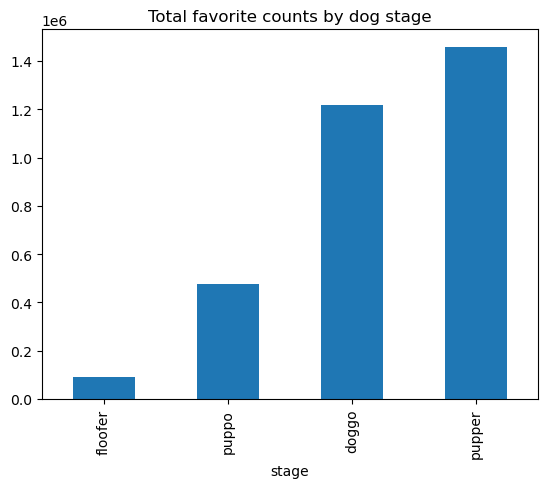

In [77]:
df_favorite_count.plot(kind = 'bar', title="Total favorite counts by dog stage")

In [78]:
df_retweet_count = df_stage.groupby('stage').retweet_count.sum().sort_values()
df_retweet_count

stage
floofer     34781
puppo      142427
doggo      448919
pupper     478883
Name: retweet_count, dtype: int64

<AxesSubplot:title={'center':'Total retweet counts by dog stage'}, xlabel='stage'>

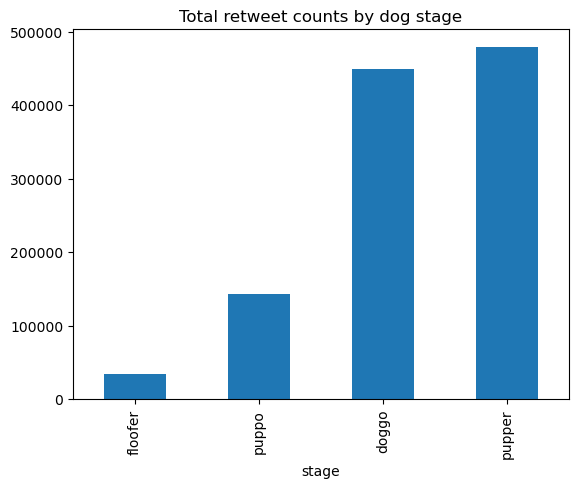

In [79]:
df_retweet_count.plot(kind = 'bar', title="Total retweet counts by dog stage")

2- Are columns retweet_count and favorite_count correlated?

In [63]:
df[['retweet_count','favorite_count']].corr()

,retweet_count,favorite_count
retweet_count,1.000000,0.912217
favorite_count,0.912217,1.000000


Text(0, 0.5, 'favorite count')

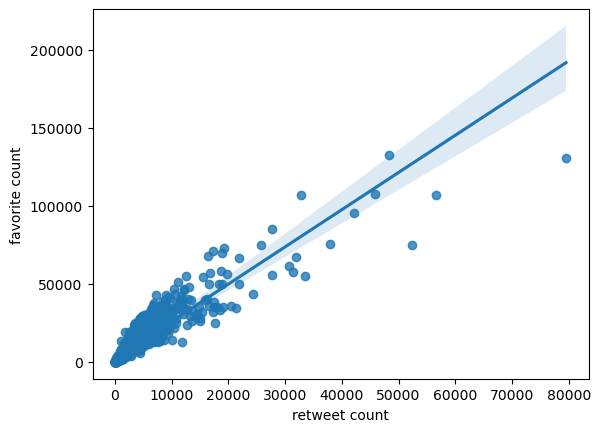

In [66]:
#to visualise this we'll generate a scatterplot with a regression line
import seaborn as sns
sns.regplot(x=df.retweet_count, y=df.favorite_count)
plt.xlabel('retweet count')
plt.ylabel('favorite count')

3- Which dog stage has the highest average rating ?

In [80]:
#Since we have the rating split into 2 columns, we'll creat a new column called rating
df_stage['rating'] = df_stage['rating_numerator']/df_stage['rating_denominator']
df_stage['rating'].head()

C:\Users\Hind\AppData\Local\Temp\ipykernel_9600\3209784188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stage['rating'] = df_stage['rating_numerator']/df_stage['rating_denominator']


9     1.4
12    1.3
14    1.3
28    1.2
37    1.2
Name: rating, dtype: float64

In [81]:
df_rating = df_stage.groupby('stage').rating.mean().sort_values()
df_rating

stage
pupper     1.071642
doggo      1.188889
floofer    1.200000
puppo      1.200000
Name: rating, dtype: float64

### Visualization

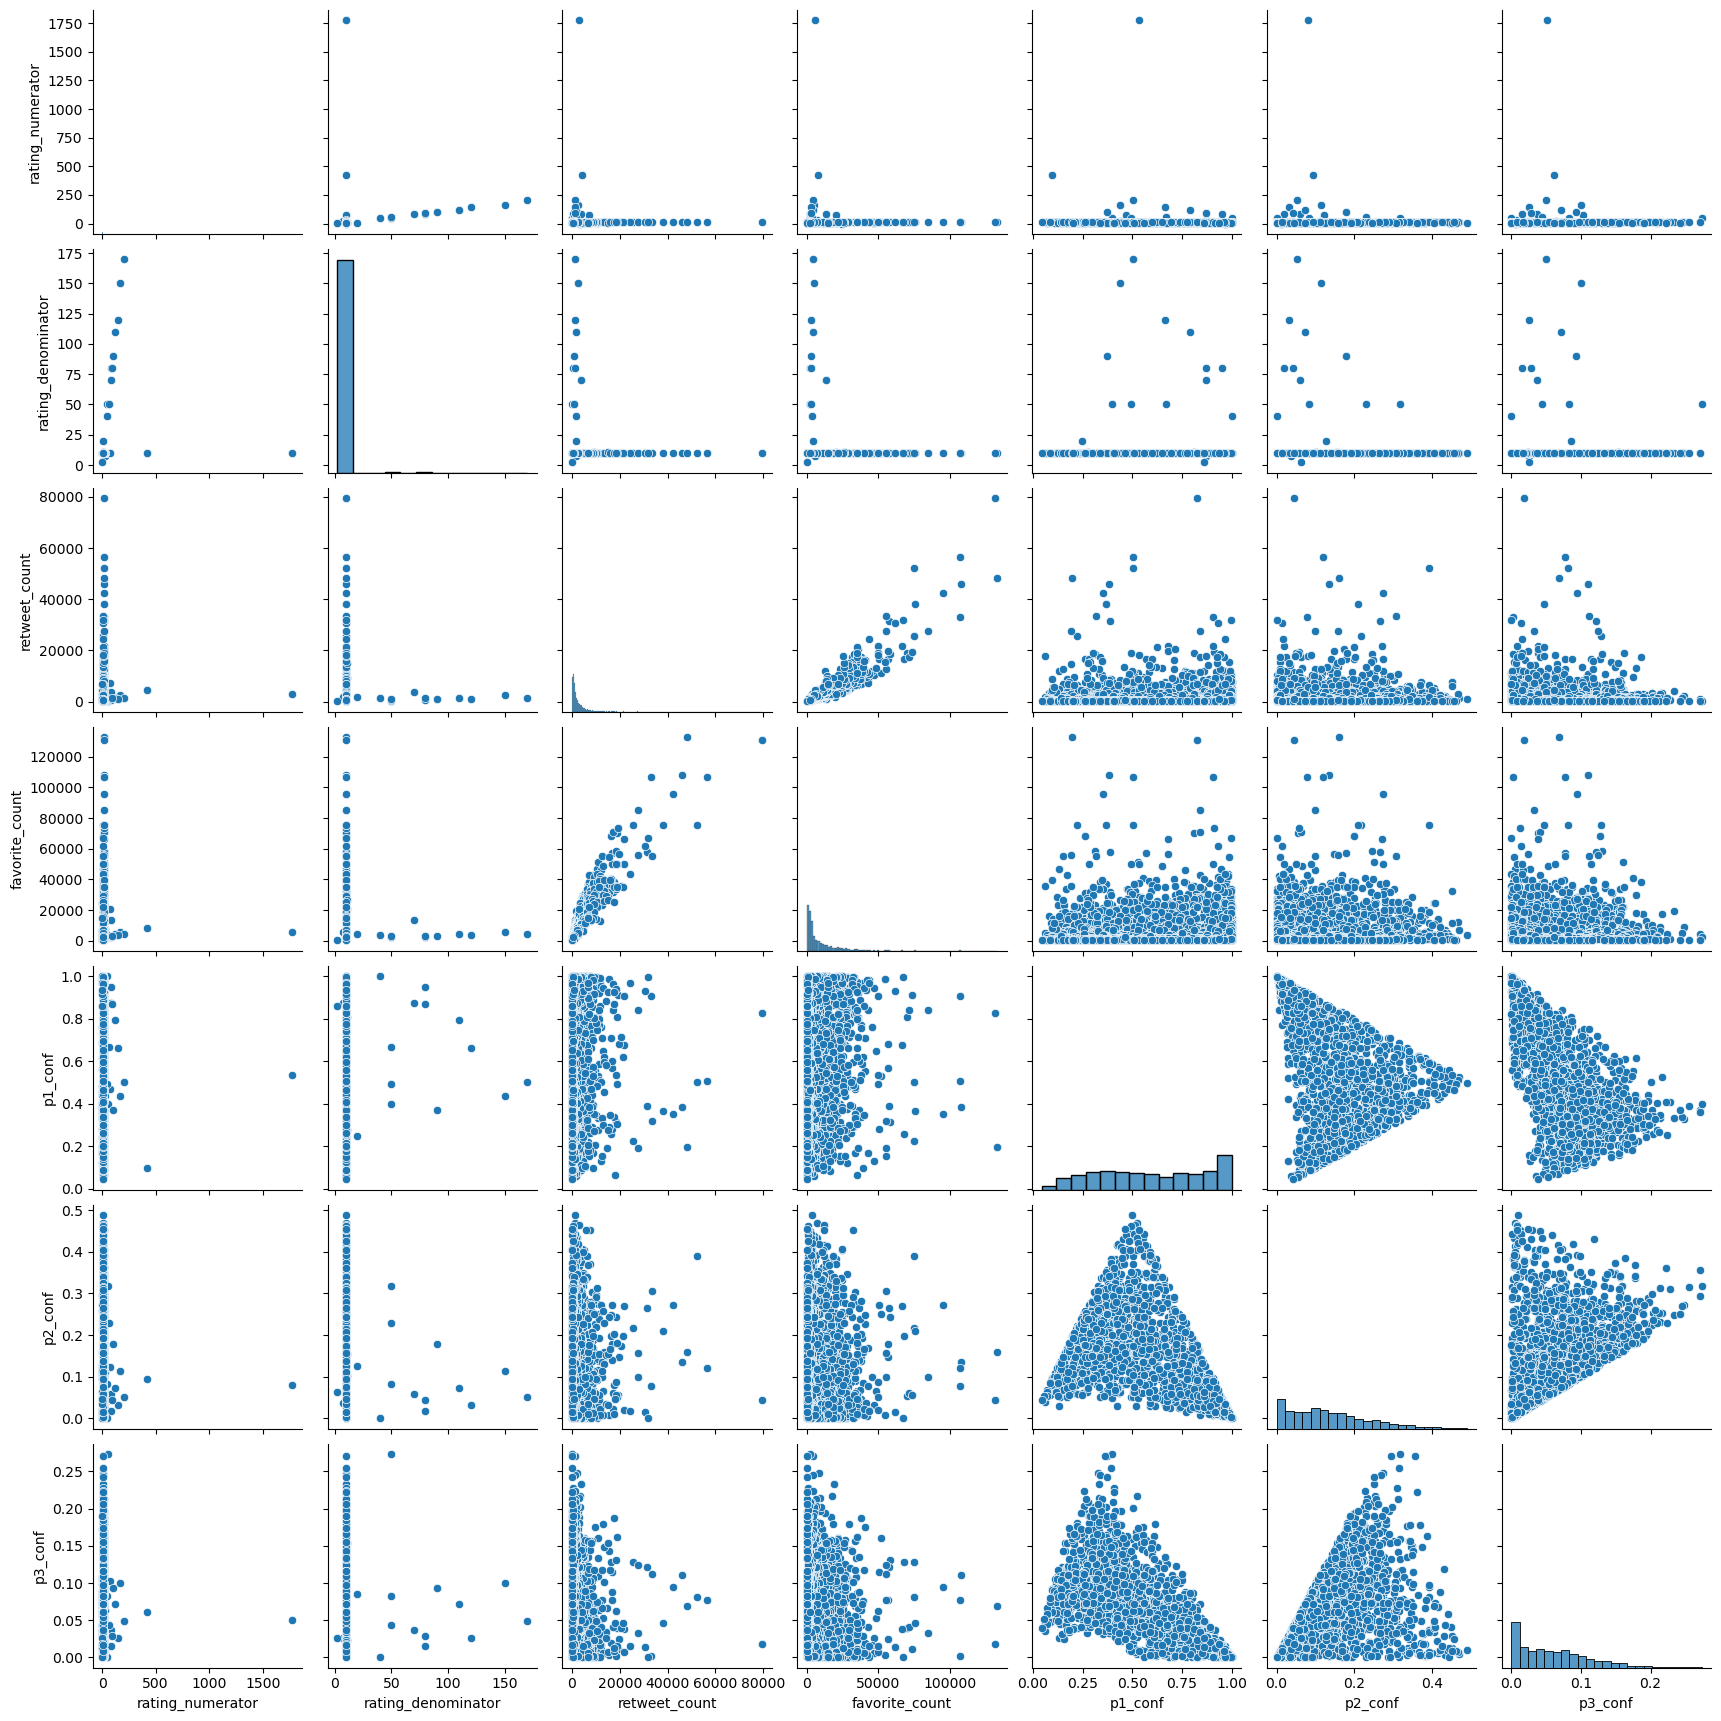

In [69]:
#visualizing the relationship between each pair of numerical variables in the dataset
sns.pairplot(df, vars=["rating_numerator", "rating_denominator", "retweet_count", "favorite_count", "p1_conf", "p2_conf", "p3_conf"]);

We notice that only the columns retweet_count and favorite_count are correlated

#### Insights
</br>1- The dog stage with the highest retweet and favorite count is pupper but that could be due to the fact that the pupper stage is the most dominant in the dataset
</br>2- There's a strong positive correlation (0.912217) between the retweet count and favorite count, so if the number of retweets is high then the number of favorites will certainly be high too and vice versa. Same thing for when the value is low or other.
</br>3- When it comes to highest average rating we have a tie between stages puppo and floofer